# Neural Networks for Supervised and Unsupervised Training (Regression)
+ Pendulum Dataset
+ Supervised Learning using a Neural Network
    + Setting up a Neural Network
+ Physics knowledge of the Hamiltonian System
    + Unsupervised Learning using a Neural Network

# The Simple Pendulum

![A simple pendulum. Its position is defined by $\theta$ and the velocity is defined as $v$](https://upload.wikimedia.org/wikipedia/commons/thumb/2/24/Oscillating_pendulum.gif/300px-Oscillating_pendulum.gif)

A simple pendulum. Its position is defined by $\theta$ and the velocity is defined as $v$.

We consider a pendulum with mass 1kg and the length of the massless cord is 1m. It swings freely back and forth. 

The rate of change of the position of the pendulum is $\frac{d\theta}{dt}$ and the rate of change of the acceleration of the pendulum is $\frac{dv}{dt}$. The acceleration of the pendulum is also $\frac{d^2 \theta}{dt^2} = -\sin\theta$. You can refer to [this website](https://www.acs.psu.edu/drussell/Demos/Pendulum/Pendula.html#:~:text=A%20simple%20pendulum%20consists%20of,and%20forth%20with%20periodic%20motion.) for more details about the simple pendulum.



In [ ]:
! git clone https://github.com/zykhoo/IT5006.git

Cloning into 'IT5006'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


We import our dataset of (left to right, by column):
+ randomly sampled positions within the range of $[-2\pi, 2\pi]$, $\theta_1$
+ randomly sampled velocities within the range of $[-1.2,1.2]$, $v_1$
+ the derivative of each position, $\frac{\theta2 -\theta_1}{t}$
+ the derivative of each velocity, $\frac{v_2-v_1}{t}$


In [ ]:
import pandas as pd
df = pd.read_csv("/content/IT5006/pq_data.txt", sep = ',', header = None)
df.columns = ["theta","v","dtheta","dv"]
df.head()

,theta,v,dtheta,dv
0,-4.712389,-0.133333,-0.183624,-1.001201
1,1.570796,0.666667,0.617392,-1.000588
2,-1.570796,-0.666667,-0.617392,1.000588
3,4.712389,0.133333,0.183624,1.001201
4,-5.497787,0.933333,0.897999,-0.739223


# The Neural Network

We want to use a neural network to take in $\theta$ and $v$, and return the rate of change of the position and velocity. $NN(\theta,v)=(\frac{d\theta}{dt},\frac{dv}{dt})$.

This is a **supervised learning** example because we know the rate of change of the position and velocity.

The neural network is basically approximating the functions $\frac{d\theta}{dt} = v$ and $\frac{dv}{dt} = -\sin(\theta)$. However, it does not know the equation, but instead uses several layers of perceptrons to approximate these equations. The neural network is a **black box model**.

We can use a neural network to approximate these functions (and even more complex functions!) because neural networks are [universal function approximators](https://www.sciencedirect.com/science/article/abs/pii/0893608089900208). This applies to any neural network with at least one hidden layer. 

We use [pytorch](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) to set up our neural network.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import os
import time

We create a neural network with one input layer, and three hidden layers (inclusive of the output layer). Each hidden layer has 16 neurons, and the output layer has 2 neurons, as there are 2 outputs $\frac{d\theta}{dt}$ and $\frac{dv}{dt}$. It uses the softplus activation function. ![softplus activation](https://pytorch.org/docs/stable/_images/Softplus.png)

In [ ]:
# define model
def softplus(x):
    return torch.log(torch.exp(x)+1)

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net , self).__init__()
        self.hidden_layer_1 = nn.Linear( input_size, hidden_size, bias=True)
        self.hidden_layer_2 = nn.Linear( hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear( hidden_size, output_size , bias=True)
        
    def forward(self, x):
        x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
        x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
        x = self.output_layer(x)

        return x

In [ ]:
# let's create the neural network. how many layers does it have?
net = Net(2, 16, 2)
print(net)

Net(
  (hidden_layer_1): Linear(in_features=2, out_features=16, bias=True)
  (hidden_layer_2): Linear(in_features=16, out_features=16, bias=True)
  (output_layer): Linear(in_features=16, out_features=2, bias=True)
)


We also need to choose the device to run our neural network on, and store our data. We make use of the context-manager that changes the selected device, ```torch.device()```. We use 'cpu' if we run our neural network on our CPU, and 'cuda' if we run our neural network on our GPU.

When do we use GPUs? Training neural networks is a hardware intensive task which requires many small numerical calculations. A decent GPU will make sure these computations go smoothly. For the purpose of this tutorial, we do not need to use a GPU because our neural network is small and there are fewer numerical calculations. The CPU suffices. However, for other tasks such as image recognition or natural language processing, a GPU can significantly improve performance.  

In [ ]:
device=torch.device('cpu')
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

## Dataset Creation

Let's create the matrix that we use for our neural network. This matrix comprises the input and the groundtruth output of the neural network, for supervised learning. We make use of sklearn's train_test_split to split this dataset into a training and validation dataset. The training dataset is used to train the neural network. The validation data set provides an unbiased evaluation of a model fit on the training data set.

In [ ]:
df.head()

,theta,v,dtheta,dv
0,-4.712389,-0.133333,-0.183624,-1.001201
1,1.570796,0.666667,0.617392,-1.000588
2,-1.570796,-0.666667,-0.617392,1.000588
3,4.712389,0.133333,0.183624,1.001201
4,-5.497787,0.933333,0.897999,-0.739223


In [ ]:
from sklearn.model_selection import train_test_split

mat = df.to_numpy()
mat = torch.from_numpy(mat)
mat = mat.to(device)

# split the dataset into training and validation sets
wholemat, evalmat = train_test_split(mat, train_size = 0.8, shuffle = True, random_state = 1)

## Optimizer

The optimizer we use is the [Adam optimizer](https://paperswithcode.com/method/adam), which is adaptive and gradually decreases the learning rate as the number of epochs increase.

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.01)


## Training the Neural Network

We train the neural network for 1600 epochs and realise the validation loss has stagnated. We observe this by printing the validation loss every 10 epochs. 

As our dataset is small, we can make use of the entire dataset when training the neural network in each epoch. If the dataset is larger, we can split the dataset into batches and train one batch at a time per each epoch.

For every epoch, we feed the inputs into the neural network, and calculate the mean squared error loss between the output of the neural network and the groundtruth. We then backpropagate through the neural network using this loss, and update the weights of the neural network using Adam and the loss. 




In [ ]:
for epoch in range(1600):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # for count in range(0,len(wholemat),batchsize):
    # get the inputs; data is a list of [inputs, labels]
    input = wholemat[:,0:2].float()

    # forward + backward + optimize
    outputs = net(input) # we feed the inputs into the neural network
    loss = torch.mean((outputs - wholemat[:,2:4])**2) # calculate the mean squared error loss between the output of the neural network and the groundtruth
    loss.backward() # backpropagate through the neural network using this loss
    optimizer.step() # update the weights of the neural network using Adam and the loss

    # print statistics
    if epoch % 10 == 0:    
        print("training loss", loss)
        net.eval() # this means that we are evaluating the neural network. the validation loss is not used for backpropagation
        print("validation loss", torch.mean((net(evalmat[:,0:2].float()) - evalmat[:,2:4])**2))

print('Finished Training')

training loss tensor(0.4523, dtype=torch.float64, grad_fn=<MeanBackward0>)
validation loss tensor(0.5567, dtype=torch.float64, grad_fn=<MeanBackward0>)
training loss tensor(0.3769, dtype=torch.float64, grad_fn=<MeanBackward0>)
validation loss tensor(0.4529, dtype=torch.float64, grad_fn=<MeanBackward0>)
training loss tensor(0.2694, dtype=torch.float64, grad_fn=<MeanBackward0>)
validation loss tensor(0.2918, dtype=torch.float64, grad_fn=<MeanBackward0>)
training loss tensor(0.2230, dtype=torch.float64, grad_fn=<MeanBackward0>)
validation loss tensor(0.2940, dtype=torch.float64, grad_fn=<MeanBackward0>)
training loss tensor(0.2011, dtype=torch.float64, grad_fn=<MeanBackward0>)
validation loss tensor(0.2298, dtype=torch.float64, grad_fn=<MeanBackward0>)
training loss tensor(0.1960, dtype=torch.float64, grad_fn=<MeanBackward0>)
validation loss tensor(0.2291, dtype=torch.float64, grad_fn=<MeanBackward0>)
training loss tensor(0.1793, dtype=torch.float64, grad_fn=<MeanBackward0>)
validation lo

In [ ]:
net(torch.tensor([1.0,0.1]))

tensor([ 0.0469, -0.8474], grad_fn=<AddBackward0>)

## Plotting the result

Let's plot the output $\frac{d\theta}{dt}$ and $\frac{dv}{dt}$ of the neural network and compare it against the groundtruth $\frac{d\theta}{dt}$ and $\frac{dv}{dt}$.

In [ ]:
import matplotlib.pyplot as plt

x,y = np.meshgrid(np.linspace(np.min(df['theta'])*1.1, np.max(df['theta'])*1.1,20), np.linspace(np.min(df['v'])*1.1, np.max(df['v'])*1.1,20))
net_output_derivatives = net(torch.tensor(np.c_[np.ravel(x), np.ravel(y)]).float()).detach().numpy()
dtheta, dv = net_output_derivatives[:,0].reshape(x.shape), net_output_derivatives[:,1].reshape(y.shape)

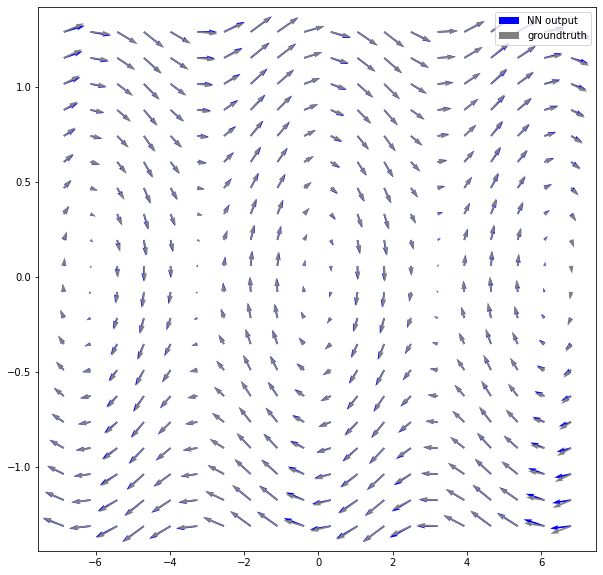

In [ ]:
plt.figure(figsize = (10,10))
plt.quiver(x,y,dtheta,dv, color = 'blue', label = 'NN output')
plt.quiver(x,y,y,-np.sin(x), color = 'grey', label = 'groundtruth')
plt.legend()

# Learning the total energy of the system

For physical systems, their total energy $H$ is conserved. We can use this information to train a neural network to evaluate the total energy of a neural network, given $\theta$ and $v$. This type of system (with total energy that is conserved), is also called a Hamiltonian system [1](https://en.wikipedia.org/wiki/Hamiltonian_system) [2](https://en.wikipedia.org/wiki/Hamiltonian_system). 

Hamiltonian systems follow the Hamilton's equations:
$\frac{dv}{dt} = -\frac{\partial H}{\partial \theta}$, $\frac{d\theta}{dt} = \frac{\partial H}{\partial v}$. Furthermore, we know that a system at rest with $\theta=0$ and $v=0$ has a total energy of $H=0$.

This is the **knowledge/information** that we have about the Hamiltonian system. We want to *embed this knowledge in the loss function* of a neural network to *constrain the neural network* and bias it toward learning the total energy of our system.

This is *physics-informed machine learning*, and is **unsupervised**. 

Automatic differentiation relies on a classic calculus formula known as the chain-rule. The chain rule allows us to calculate very complex derivatives by splitting them and recombining them later.

Formally speaking, given a composite function $f(g(x))$, we can calculate its derivative as $\frac{\partial}{\partial x} f(g(x)) = f'(g(x))g'(x)$. This result is what makes automatic differentiation work. By combining the derivatives of the simpler functions that compose a larger one, such as a neural network, it is possible to compute the exact value of the gradient at a given point rather than relying on the numerical approximation, which would require multiple perturbations in the input to obtain a value.

Using this concept, we can compute the derivative of the output of a neural network $f(x)$ with respect to its inputs $x$

In [ ]:
Hnet = Net(2,16,1)

In [ ]:
def calculate_loss(Hnet, mat):
  input    = torch.autograd.Variable(mat[:,0:2].float(),requires_grad=True) # requires_grad = True for automatic differentiation
  outputs  = Hnet(input) # we feed the inputs into the neural network, and want the output to be the total energy of the system
  dH       = torch.autograd.grad(outputs, input, grad_outputs=outputs.data.new(outputs.shape).fill_(1),create_graph=True)[0]
  dHdtheta = dH[:,0]
  dHdv     = dH[:,1]
  dthetadt = mat[:,2]
  dvdt     = mat[:,3]

  loss1 = torch.mean((dHdv-dthetadt)**2,dim=0)
  loss2 = torch.mean((dHdtheta+dvdt)**2,dim=0) 
  loss3 = (Hnet(torch.tensor([[0.,0.]]).to(device))-torch.tensor([[0.]]).to(device))**2 # a system at rest has 0 energy

  return loss1, loss2, loss3

In [ ]:
optimizer = optim.Adam(Hnet.parameters(), lr=0.01)

for epoch in range(500):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # calculating the loss
    loss1, loss2, loss3 = calculate_loss(Hnet, wholemat)

    # forward + backward + optimize
    loss = loss1 + loss2 + loss3  #calculate the mean squared error loss between the output of the neural network and the groundtruth
    loss.backward() # backpropagate through the neural network using this loss
    optimizer.step() # update the weights of the neural network using Adam and the loss

    # print statistics
    if epoch % 10 == 0:    
        print("training loss", loss[0][0])
        Hnet.eval()
        loss1, loss2, loss3 = calculate_loss(Hnet, evalmat)
        print("validation loss from each equation: loss1 = %s, loss2 = %s, loss3 = %s" %(loss1.detach().cpu().item(), loss2.detach().cpu().item(), loss3.detach().cpu().item()))

print('Finished Training')

training loss tensor(1.1373, grad_fn=<SelectBackward0>)
validation loss from each equation: loss1 = 0.656070385207856, loss2 = 0.5419186597160505, loss3 = 0.05287189409136772
training loss tensor(0.9130, grad_fn=<SelectBackward0>)
validation loss from each equation: loss1 = 0.6455690920335235, loss2 = 0.5323057772273769, loss3 = 0.008689397014677525
training loss tensor(0.8960, grad_fn=<SelectBackward0>)
validation loss from each equation: loss1 = 0.6327886862456241, loss2 = 0.5240447618863968, loss3 = 0.004323943518102169
training loss tensor(0.8668, grad_fn=<SelectBackward0>)
validation loss from each equation: loss1 = 0.6108453799912674, loss2 = 0.5062713065650273, loss3 = 0.0019183979602530599
training loss tensor(0.8042, grad_fn=<SelectBackward0>)
validation loss from each equation: loss1 = 0.5359813810841297, loss2 = 0.477510498788299, loss3 = 0.0028277868404984474
training loss tensor(0.6747, grad_fn=<SelectBackward0>)
validation loss from each equation: loss1 = 0.34539913915304

# Plotting the result

In [ ]:
import matplotlib.pyplot as plt

x,y = np.meshgrid(np.linspace(np.min(df['theta'])*1.1, np.max(df['theta'])*1.1,200), np.linspace(np.min(df['v'])*1.1, np.max(df['v'])*1.1,200))
net_output_Hamiltonian = Hnet(torch.tensor(np.c_[np.ravel(x), np.ravel(y)]).float()).detach().numpy()
H_output = net_output_Hamiltonian.reshape(x.shape)

In [ ]:
def H_true(x,y):
  return 0.5*y**2 + 1 - np.cos(x)

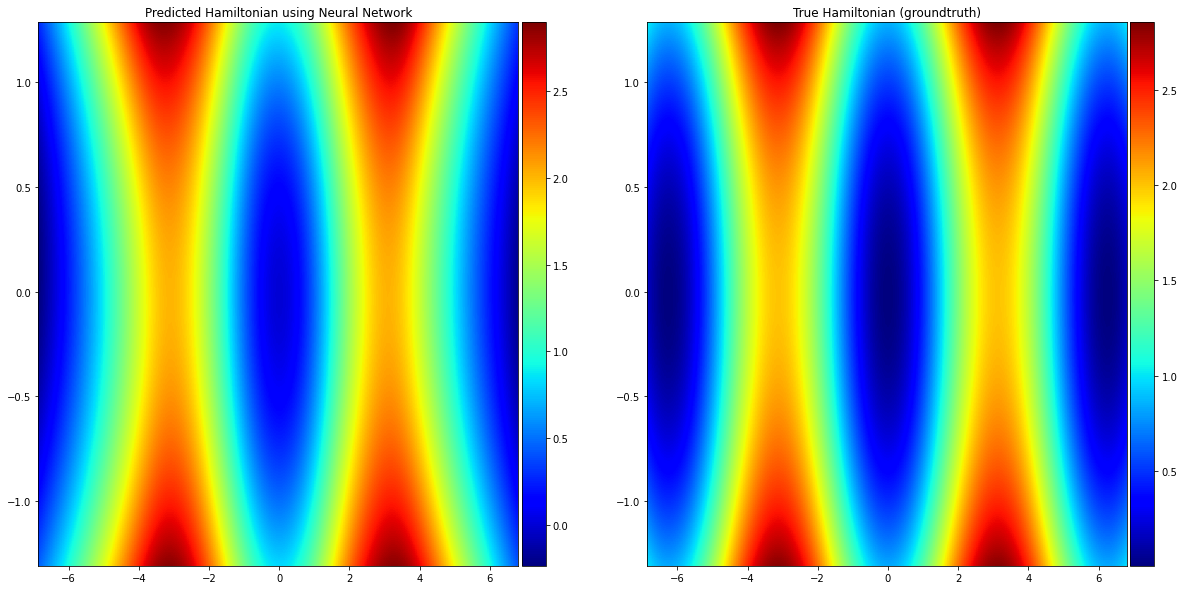

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,2,figsize = (20,10))

im0 = ax[0].imshow(H_output, extent = (np.min(df['theta'])*1.1, np.max(df['theta'])*1.1, np.min(df['v'])*1.1, np.max(df['v'])*1.1), cmap = plt.cm.jet, aspect = 'auto')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
ax[0].title.set_text("Predicted Hamiltonian using Neural Network")

im1 = ax[1].imshow(H_true(x,y), extent = (np.min(df['theta'])*1.1, np.max(df['theta'])*1.1, np.min(df['v'])*1.1, np.max(df['v'])*1.1), cmap = plt.cm.jet, aspect = 'auto')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax[1].title.set_text("True Hamiltonian (groundtruth)")